### 说明
本次分析使用了测序量分别为1G,2G, 3G, 4G, 5G, 6G, 7G, 8G, 9G,10G的10个模拟样本，每个样本包含69个species，梯度分为1，10，100，1000，10000，与陈博的真实样本保持一致，具体可以看表2。  
### 模拟样本的生成
测序量是以给定的测序量为期望值，方差为期望值的5%的正太分布生成的随机数，并去掉与期望值差距超过一倍方差的样本。也就是说对于1G的样本，模拟产生的测序量为0.95G-1.05G之间。  

对于每一个样本，以各个species的相对丰度为概率随机抽取reads，比如对于相对丰度为1%的species，则产生的reads来自于该species的概率为1%，但这是一个随机数，不排除来自于该species的reads为0的可能。  

reads来自于单菌的测序结果。对于模拟数据量大，单菌测序的reads不足的情况，会存在同一条reads被抽取两次甚至多次的情况，但这会在生成的reads名称中标记出来。

In [96]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [97]:
class MergeMetaphlan2:
    def __init__(self, filelist, pat=True):
        self.filelist = pat and glob.glob(filelist) or filelist
    def merge(self):
        file = self.filelist[0]
        sampleName = os.path.basename(file).strip('_metagenome.txt')
        meta = pd.read_csv(file, sep='\t', skiprows=1, header=None, index_col=0, names=[sampleName,])
        for file in self.filelist[1:]:
            sampleName = os.path.basename(file).strip('_metagenome.txt')
            tmp = pd.read_csv(file, sep='\t', skiprows=1, header=None, index_col=0, names=[sampleName,])
            meta = pd.concat([tmp, meta], axis=1, join='outer', sort=False)
        meta.fillna(0, inplace=True)
        self.meta = meta

In [98]:
rawMetaphlan2File = 'mock_metaphlan2/metaphlan2_outdir/*metagenome.txt'
mergeObj = MergeMetaphlan2(rawMetaphlan2File)
mergeObj.merge()
mergeObj.meta.to_csv("result/mock_metagenome_merged.txt", sep='\t', index_label=False)

In [99]:
class GetLevelAbundance:
    def __init__(self, meta):
        self.meta = meta.copy()
        self.meta.index = self.meta.index.str.replace('\|', ';')
        self.meta.index = self.meta.index.str.replace(' ', '_')
    def getAbundance(self, level='genus'):
        if level == 'genus':
            genus = self.meta[self.meta.index.str.contains('g__')]
            self.genus = genus[~(genus.index.str.contains('s__') | genus.index.str.contains('t__'))]
            self.genus.index.name = 'taxonomy'
            self.genus.reset_index(inplace=True)
            self.genus.taxonomy = self.genus.taxonomy.str.replace("^.*;g__", "")
        elif level == 'species':
            species = self.meta[self.meta.index.str.contains('s__')]
            self.species = species[~species.index.str.contains('t__')]
            self.species.index.name = 'taxonomy'
            self.species.reset_index(inplace=True)
            self.species.taxonomy = self.species.taxonomy.str.replace("^.*;s__", "")

In [100]:
meta = mergeObj.meta
#meta = pd.read_csv("result/metagenome_merged.txt", sep='\t', header=0, index_col=0)  #如果单独运行这个cell，需要读入数据
abundance = GetLevelAbundance(meta)
#abundance.getAbundance('genus')
abundance.getAbundance('species')
#abundance.genus.to_csv("result/genus_relativeQuanti_meta.txt",  sep='\t', header=True, index=False)
abundance.species.to_csv("result/mock_species_relativeQuanti_meta.txt",  sep='\t', header=True, index=False)

In [101]:
speciesAbund = pd.read_csv("result/mock_species_relativeQuanti_meta.txt",  sep='\t', header=0)
speciesAbund['taxonomy'] = speciesAbund.taxonomy.str.replace("_", " ")
std_species = pd.read_csv("sampleinfo/std_species", header=None, sep='\t', names=['taxonomy'])
std_species['y_true'] = 1
speciesAbund.set_index('taxonomy', inplace=True)
speciesAbund = speciesAbund.filter(regex='0$', axis=1)

### 不同测序深度下的精度和召回率

In [102]:
result = speciesAbund.applymap(lambda x: 1 if x>0.0000001 else 0)
result = pd.merge(result, std_species, on='taxonomy', how='outer')
result.fillna(0, downcast='infer', inplace=True)
result = pd.melt(result, id_vars=['taxonomy', 'y_true'], var_name='sampleName', value_name='y_pred')
result['TP'] = np.logical_and(result.y_true, result.y_pred).astype(int)
deepOrder = sorted(result.sampleName.unique(), key=lambda x: int(x.split('_')[1].strip('G')))
result['sampleName'] = pd.Categorical(result['sampleName'], ordered=True, categories=deepOrder)
r = result.groupby('sampleName').sum()
r['recall'] = r.TP/r.y_true
r['precision'] = r.TP/r.y_pred
r

,y_true,y_pred,TP,recall,precision
sampleName,,,,,
Mock_1G_0,69,46,39,0.565217,0.847826
Mock_2G_0,69,57,44,0.637681,0.771930
Mock_3G_0,69,59,44,0.637681,0.745763
Mock_4G_0,69,59,44,0.637681,0.745763
Mock_5G_0,69,63,48,0.695652,0.761905
Mock_6G_0,69,71,52,0.753623,0.732394
Mock_7G_0,69,72,52,0.753623,0.722222
Mock_8G_0,69,75,51,0.739130,0.680000
Mock_9G_0,69,76,52,0.753623,0.684211


                               表1

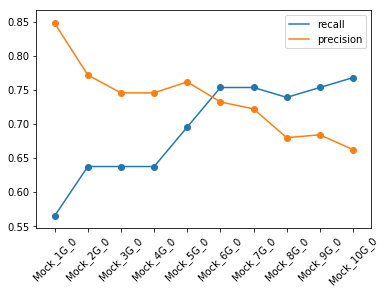

In [103]:
plt.plot(r.reset_index().index, r.recall, label='recall')
plt.scatter(r.index, r.recall, label='recall')
plt.xticks(rotation=45)
plt.plot(r.reset_index().index, r.precision, label='precision')
plt.scatter(r.index, r.precision, label='precision')
plt.legend(labels=['recall', 'precision'])

                                图1

### 不同梯度的精度和召回率

In [104]:
info = pd.read_csv("sampleinfo/info_20190507.txt", sep='\t', header=0)
result_grad = result.set_index('taxonomy').drop('y_pred', axis=1)
result_grad['stdAbundance'] = info[['stdAbundance', 'searchName']].set_index("searchName").stdAbundance
result_grad.stdAbundance.fillna(0, inplace=True, downcast='infer')
result_grad = result_grad[result_grad.stdAbundance!=0]

In [105]:
r_grad = result_grad.groupby(['sampleName', 'stdAbundance']).sum()
r_grad['recall'] = r_grad.TP/r_grad.y_true
r_grad.to_csv("result/mock_gradient_recall.txt", sep='\t', header=True, index=True)
r_grad

y_true  TP    recall
sampleName stdAbundance                      
Mock_1G_0  1                 14   1  0.071429
           10                14   0  0.000000
           100               14  11  0.785714
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_2G_0  1                 14   1  0.071429
           10                14   4  0.285714
           100               14  12  0.857143
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_3G_0  1                 14   1  0.071429
           10                14   3  0.214286
           100               14  13  0.928571
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_4G_0  1                 14   1  0.071429
           10                14   3  0.214286
           100               14  13  0.928571
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_5G_0  1                 14   1  0.071429
           10                14   7  0.500000
           100               14  13  0.928571
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_6G_0  1                 14   1  0.071429
           10                14  10  0.714286
           100               14  14  1.000000
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_7G_0  1                 14   1  0.071429
           10                14  10  0.714286
           100               14  14  1.000000
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_8G_0  1                 14   1  0.071429
           10                14   9  0.642857
           100               14  14  1.000000
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_9G_0  1                 14   1  0.071429
           10                14  10  0.714286
           100               14  14  1.000000
           1000              14  14  1.000000
           10000             13  13  1.000000
Mock_10G_0 1                 14   1  0.071429
           10                14  11  0.785714
           100               14  14  1.000000
           1000              14  14  1.000000
           10000             13  13  1.000000

                    表2

##### 可以看到在不同深度下，梯度为1的species中总有一个species被检测到，为了解释这一情况，看下面的结果。可以看到每个深度都是同一个species：Clostridium bifermentans

In [106]:
result_grad[np.logical_and(result_grad.stdAbundance==1, result_grad.TP==1)]

,y_true,sampleName,TP,stdAbundance
taxonomy,,,,
Clostridium bifermentans,1,Mock_8G_0,1,1
Clostridium bifermentans,1,Mock_10G_0,1,1
Clostridium bifermentans,1,Mock_9G_0,1,1
Clostridium bifermentans,1,Mock_7G_0,1,1
Clostridium bifermentans,1,Mock_2G_0,1,1
Clostridium bifermentans,1,Mock_4G_0,1,1
Clostridium bifermentans,1,Mock_5G_0,1,1
Clostridium bifermentans,1,Mock_1G_0,1,1
Clostridium bifermentans,1,Mock_6G_0,1,1


                              表3

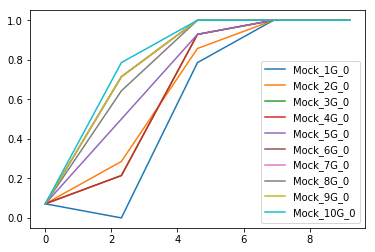

In [107]:
plotdata = r_grad.reset_index()
for i in deepOrder:
    tmp=plotdata[plotdata.sampleName==i]
    plt.plot(np.log(tmp.stdAbundance), tmp.recall, label=i)
plt.legend()
plt.show()

                                 图2

In [108]:
r_grad.index = r_grad.index.swaplevel()

In [109]:
r_grad.sort_index(axis=0, level=0)

y_true  TP    recall
stdAbundance sampleName                      
1            Mock_1G_0       14   1  0.071429
             Mock_2G_0       14   1  0.071429
             Mock_3G_0       14   1  0.071429
             Mock_4G_0       14   1  0.071429
             Mock_5G_0       14   1  0.071429
             Mock_6G_0       14   1  0.071429
             Mock_7G_0       14   1  0.071429
             Mock_8G_0       14   1  0.071429
             Mock_9G_0       14   1  0.071429
             Mock_10G_0      14   1  0.071429
10           Mock_1G_0       14   0  0.000000
             Mock_2G_0       14   4  0.285714
             Mock_3G_0       14   3  0.214286
             Mock_4G_0       14   3  0.214286
             Mock_5G_0       14   7  0.500000
             Mock_6G_0       14  10  0.714286
             Mock_7G_0       14  10  0.714286
             Mock_8G_0       14   9  0.642857
             Mock_9G_0       14  10  0.714286
             Mock_10G_0      14  11  0.785714
100          Mock_1G_0       14  11  0.785714
             Mock_2G_0       14  12  0.857143
             Mock_3G_0       14  13  0.928571
             Mock_4G_0       14  13  0.928571
             Mock_5G_0       14  13  0.928571
             Mock_6G_0       14  14  1.000000
             Mock_7G_0       14  14  1.000000
             Mock_8G_0       14  14  1.000000
             Mock_9G_0       14  14  1.000000
             Mock_10G_0      14  14  1.000000
1000         Mock_1G_0       14  14  1.000000
             Mock_2G_0       14  14  1.000000
             Mock_3G_0       14  14  1.000000
             Mock_4G_0       14  14  1.000000
             Mock_5G_0       14  14  1.000000
             Mock_6G_0       14  14  1.000000
             Mock_7G_0       14  14  1.000000
             Mock_8G_0       14  14  1.000000
             Mock_9G_0       14  14  1.000000
             Mock_10G_0      14  14  1.000000
10000        Mock_1G_0       13  13  1.000000
             Mock_2G_0       13  13  1.000000
             Mock_3G_0       13  13  1.000000
             Mock_4G_0       13  13  1.000000
             Mock_5G_0       13  13  1.000000
             Mock_6G_0       13  13  1.000000
             Mock_7G_0       13  13  1.000000
             Mock_8G_0       13  13  1.000000
             Mock_9G_0       13  13  1.000000
             Mock_10G_0      13  13  1.000000

                      表4

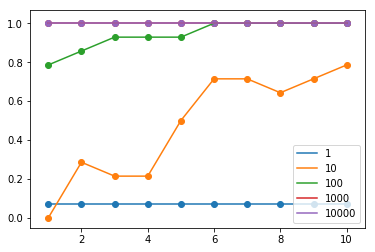

In [110]:
plotdata['deep'] = plotdata.sampleName.apply(lambda x: int(x.split('_')[1].strip('G')))
plotdata['deep'] = plotdata.deep.astype(np.int32)
for i in plotdata.stdAbundance.unique():
    tmp = plotdata[plotdata.stdAbundance==i]
    plt.scatter(tmp.deep, tmp.recall)
    plt.plot(tmp.deep, tmp.recall, label=i)
plt.legend(loc='lower right', labels=[1,10,100,1000,10000])

                              图3

测序深度与species的相对丰度的乘积代表了该species的测序量，图4可以看出，随着测序量的增加，召回率是递增的

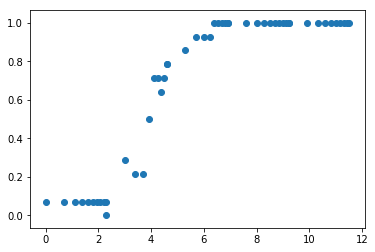

In [111]:
plotdata['reads'] = plotdata.stdAbundance * plotdata.deep
plt.scatter(np.log(plotdata.reads), plotdata.recall)

                                  图4